In [126]:
#%pip install boruta scikit-learn pandas
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import Ellipse
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from boruta import BorutaPy
from collections import Counter
from itertools import chain
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample
from scipy.stats import wilcoxon
import math

## Import and Preprocess the Data 

In [129]:
#Load all the data and load differentially expressed genes

RNA_seq_all = pd.read_csv("Human RNA-seq data (Entrez).csv")
DEG = pd.read_csv ("Differentially expressed genes mucosal RNAseq - week 4 vs baseline.csv")

In [131]:
RNA_seq_all.shape

(10809, 31)

In [133]:
RNA_seq_all.head()

,Entrez(Gene)_ID,1A,2A,3A,4A,5A,6A,7A,8A,9A,...,6C,7C,8C,9C,10C,11C,12C,13C,14C,15C
0,4537,135728,92648,40999,83165,74651,49557,113780,43080,141625,...,85610,122421,132901,155220,137239,159596,218583,109955,186650,138957
1,4514,183379,96665,129423,43053,42441,22386,63152,35268,76462,...,42836,69945,98498,79920,102721,125070,140860,78147,120631,105546
2,4538,182181,100599,102847,53057,56973,26450,59561,28282,74868,...,42991,61064,73256,85586,78720,124370,136441,71421,131616,87300
3,378938,92928,41778,48657,65542,44115,46642,39790,43710,66385,...,63077,75206,79614,83127,143223,96500,82050,97327,115287,50618
4,4508,115178,63129,66531,33137,35960,17751,41965,21607,47806,...,33891,49221,61534,65957,81328,80031,107271,56244,72387,64958


In [135]:
DEG.head()

,EntrezID,logFC,logCPM,LR,PValue,FDR,gene,description
0,54979,-6.368227,3.452422,35.348679,2.760000e-09,8.790000e-07,PLAAT2,phospholipase A and acyltransferase 2 [Source:...
1,55218,-3.446965,3.803808,14.315079,1.546210e-04,8.424146e-03,EXD2,exonuclease 3'-5' domain containing 2 [Source:...
2,646625,-3.128449,4.703188,18.758626,1.480000e-05,1.398626e-03,URAD,ureidoimidazoline (2-oxo-4-hydroxy-4-carboxy-5...
3,405753,-2.990519,6.148583,43.539044,4.160000e-11,1.800000e-08,DUOXA2,dual oxidase maturation factor 2 [Source:HGNC ...
4,54970,-2.906858,3.232868,5.690110,1.706079e-02,1.808143e-01,TTC12,tetratricopeptide repeat domain 12 [Source:HGN...


In [137]:
DEG.shape

(1104, 8)

In [139]:
# Your list of target genes
target_genes = ['ADAMDEC1', 'AHNAK', 'AXL', 'CXCL14', 'FBLN1', 'FHL1', 
                'GPR155', 'MYADM', 'OAT', 'SPEN', 'TCF4', 'ZBTB20', 'ZNF830']

# Filter rows where the gene column matches any of the target genes
filtered_DEG = DEG[DEG['gene'].isin(target_genes)]

# Display gene and corresponding EntrezID
print(filtered_DEG[['gene', 'EntrezID']])

          gene  EntrezID
287      AHNAK     79026
339     ZBTB20     26137
346      MYADM     91663
357       SPEN     23013
427       TCF4      6925
507     CXCL14      9547
587   ADAMDEC1     27299
705        AXL       558
727      FBLN1      2192
861        OAT      4942
867     GPR155    151556
1050    ZNF830     91603
1082      FHL1      2273


In [141]:
#left join the DEG with RNA_SEQ data AND make gene as index and drop Entrez ID

# Step 1: Ensure key columns match
# Rename 'Entrez(Gene)_ID' in RNA_seq_all to match 'EntrezID' in DEG
RNA_seq_all_renamed = RNA_seq_all.rename(columns={'Entrez(Gene)_ID': 'EntrezID'})

# Step 2: Perform left join
merged = DEG.merge(RNA_seq_all_renamed, on='EntrezID', how='left')

# Step 3: Remove unwanted coloumns 
merged = merged.drop(['logFC', 'logCPM', 'LR', 'PValue', 'FDR', 'description'], axis = 1)

# Step 4: make the gene as index and remove EntrezID
merged = merged.set_index('gene').drop(columns='EntrezID')

In [143]:
merged.shape

(1104, 30)

In [145]:
#Transpose 

merged_df = merged.T
merged_df.index.name = 'Sample_ID'

In [147]:
missings = merged_df.isna().sum()
missings = missings[missings > 0]

print (missings)

gene
MUC5AC     30
FKBP7      30
NUMBL      30
BICC1      30
SLC9A9     30
TLR7       30
PCSK9      30
HERC5      30
C3orf62    30
ADRB2      30
SLC7A2     30
NCF1C      30
FLT3LG     30
ZSCAN32    30
TCF21      30
SIGLEC6    30
dtype: int64


In [149]:
# Drop columns with missing values 

merged_df_clean = merged_df.dropna(axis=1)

In [151]:
merged_df_clean.isna().any().sum()

0

In [153]:
merged_df_clean.head(30)

gene,PLAAT2,EXD2,URAD,DUOXA2,TTC12,MYOM3,RSAD2,CASP5,TNFRSF6B,TNS4,...,CFL2,PDE1A,ADAMTS1,FOLR2,PTGS2,EFEMP1,TIGD5,BNIP1,OLFML3,RAB34
Sample_ID,,,,,,,,,,,,,,,,,,,,,
1A,20.0,141.0,63.0,0.0,0.0,4.0,0.0,145.0,0.0,8.0,...,1.0,0.0,107.0,0.0,0.0,0.0,50.0,4.0,0.0,45.0
2A,17.0,57.0,32.0,91.0,50.0,9.0,41.0,24.0,5.0,7.0,...,0.0,0.0,0.0,1.0,0.0,50.0,0.0,0.0,1.0,0.0
3A,50.0,40.0,169.0,750.0,1.0,84.0,66.0,1449.0,278.0,46.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4A,0.0,96.0,49.0,331.0,137.0,12.0,21.0,270.0,136.0,0.0,...,96.0,0.0,0.0,88.0,29.0,1.0,0.0,0.0,0.0,0.0
5A,31.0,83.0,17.0,334.0,28.0,66.0,0.0,150.0,86.0,26.0,...,35.0,0.0,0.0,0.0,2.0,0.0,54.0,14.0,0.0,0.0
6A,0.0,20.0,33.0,519.0,0.0,45.0,2.0,130.0,66.0,25.0,...,0.0,17.0,82.0,20.0,29.0,0.0,1.0,0.0,31.0,0.0
7A,12.0,48.0,56.0,0.0,41.0,90.0,47.0,67.0,0.0,0.0,...,26.0,1.0,0.0,5.0,9.0,1.0,0.0,0.0,0.0,0.0
8A,51.0,47.0,89.0,110.0,0.0,11.0,0.0,158.0,33.0,23.0,...,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,144.0
9A,89.0,30.0,70.0,311.0,69.0,1.0,23.0,172.0,315.0,47.0,...,0.0,0.0,1.0,0.0,0.0,38.0,70.0,2.0,0.0,25.0


In [155]:
#Create Timepoint coloumn 

merged_df_clean['Timepoint'] = merged_df_clean.index.map(lambda x: 'Baseline' if x.endswith('A') else 'Week 4')

/var/folders/0_/qg07x0dd5s5dkp59h7mxv64h0000gn/T/ipykernel_2353/4186238040.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_clean['Timepoint'] = merged_df_clean.index.map(lambda x: 'Baseline' if x.endswith('A') else 'Week 4')


In [157]:
#create x and y where x contain the expression and y the timepoint only 

X = merged_df_clean.drop(columns = ["Timepoint"])
y = merged_df_clean['Timepoint']

In [159]:
#Normalize the data 

X_log = np.log1p(X)

In [161]:
X_log.head()

gene,PLAAT2,EXD2,URAD,DUOXA2,TTC12,MYOM3,RSAD2,CASP5,TNFRSF6B,TNS4,...,CFL2,PDE1A,ADAMTS1,FOLR2,PTGS2,EFEMP1,TIGD5,BNIP1,OLFML3,RAB34
Sample_ID,,,,,,,,,,,,,,,,,,,,,
1A,3.044522,4.955827,4.158883,0.000000,0.000000,1.609438,0.000000,4.983607,0.000000,2.197225,...,0.693147,0.0,4.682131,0.000000,0.000000,0.000000,3.931826,1.609438,0.000000,3.828641
2A,2.890372,4.060443,3.496508,4.521789,3.931826,2.302585,3.737670,3.218876,1.791759,2.079442,...,0.000000,0.0,0.000000,0.693147,0.000000,3.931826,0.000000,0.000000,0.693147,0.000000
3A,3.931826,3.713572,5.135798,6.621406,0.693147,4.442651,4.204693,7.279319,5.631212,3.850148,...,0.000000,0.0,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000
4A,0.000000,4.574711,3.912023,5.805135,4.927254,2.564949,3.091042,5.602119,4.919981,0.000000,...,4.574711,0.0,0.000000,4.488636,3.401197,0.693147,0.000000,0.000000,0.000000,0.000000
5A,3.465736,4.430817,2.890372,5.814131,3.367296,4.204693,0.000000,5.017280,4.465908,3.295837,...,3.583519,0.0,0.000000,0.000000,1.098612,0.000000,4.007333,2.708050,0.000000,0.000000


In [163]:
# Scale x before PCA 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

## Perform PCA with ellipses covering 95% CI


In [166]:
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(X_scaled)

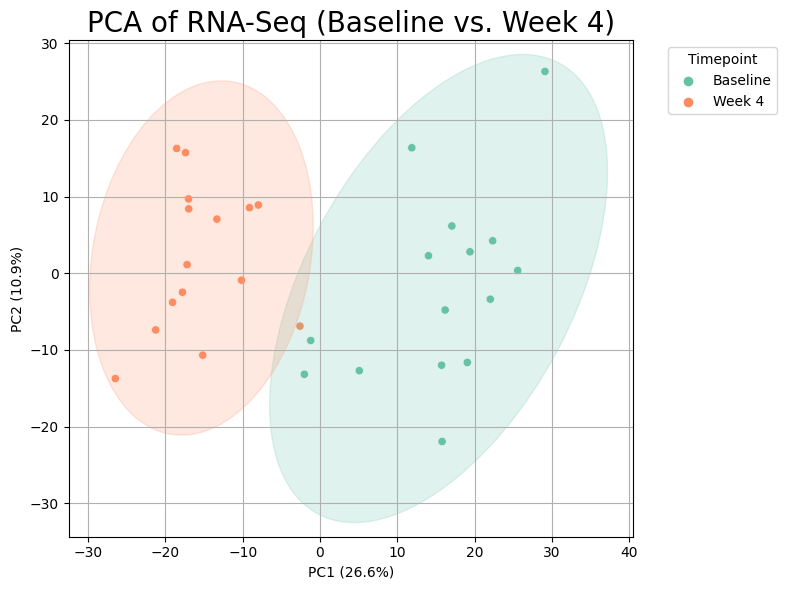

In [168]:
#Plot PCA with ellipses covering 95% CI

# Helper function to draw ellipse
def draw_ellipse(position, covariance, ax, **kwargs):
    if covariance.shape == (2, 2):
        U, s, _ = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        scale_factor = np.sqrt(chi2.ppf(0.95, df=2))  # ~2.4477
        width, height = 2 * scale_factor * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    ellipse = Ellipse(xy=position, width = width, height = height, angle = angle, **kwargs)
    ax.add_patch(ellipse)

# Step 1: Create PCA result DataFrame
pca_df = pd.DataFrame(pca_result[:, :2], columns=['PC1', 'PC2'], index=y.index)

# Step 2: Add Timepoint metadata
pca_df['Timepoint'] = merged_df_clean['Timepoint']

# Step 3: Plot PCA with ellipses
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Scatterplot
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Timepoint', palette='Set2', ax=ax)

# Add ellipses for each Timepoint group
for i, timepoint in enumerate(pca_df['Timepoint'].unique()):
    group = pca_df[pca_df['Timepoint'] == timepoint]
    if len(group) > 2:
        cov = np.cov(group[['PC1', 'PC2']].T)
        mean = group[['PC1', 'PC2']].mean().values
        draw_ellipse(mean, cov, ax, alpha=0.2, color=sns.color_palette('Set2')[i])

# Labels and formatting
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title("PCA of RNA-Seq (Baseline vs. Week 4)", fontsize = 20)
plt.legend(title='Timepoint', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig('PCA_rnasq.png')
plt.show()